In [427]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm
import math

%matplotlib inline
from scipy.optimize import curve_fit, minimize
import strax
import straxbra
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from matplotlib.ticker import AutoMinorLocator
from matplotlib.image import NonUniformImage
import pandas as pd

In [428]:
ctx = straxbra.XebraContext()

In [429]:
run = '00161'
peaks_data = ctx.get_array(run, 'peaks')

In [430]:
waveform = peaks_data['data']
integral = peaks_data['area']
width = peaks_data['width'][:,5]
timestamp = peaks_data['time']
area_per_channel = peaks_data['area_per_channel']
risetime = -peaks_data['area_decile_from_midpoint'][:,1]

In [431]:
def CutCondition(waveform):
    
    
    FirstPeak_area = sum(waveform[:15]) # range in samples (not ns!)
    SecondPeak_area = sum(waveform[15:]) # range in samples (not ns!)

    
    if  FirstPeak_area > 100 and FirstPeak_area < 600 and SecondPeak_area > 40 and SecondPeak_area  < 200: 
#        print (i , secondS1_area, secondS1_peaktime)
        return(True)
    else:
        return(False)
    

In [432]:
def PrintWaveform(waveform,i):

    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(12, 3.5))

    ax1.plot(waveform[i])
    ax2.plot(waveform[i+1])
#     ax1.set_xlim([0, 50])
    plt.show()


In [433]:
def S2_found(integral, width):
    if integral > 500 and width >200 and width < 2000:
        return True
    else:
        return False

In [434]:
def Process(waveform, i):
    CutFlag = CutCondition(waveform[i])
    if CutFlag == True:
        Timestamps_kr_events.append(timestamp[i])
        j = 1
        counter_timestamp = timestamp[i+j]
        threshold_timestamp = timestamp[i] + 65000
        while threshold_timestamp >= counter_timestamp and S2_found(integral = integral[i+j], width = width[i+j]) == False: 
            j += 1
            counter_timestamp = timestamp[i+j]           
        else:
            if S2_found(integral = integral[i+j], width = width[i+j]):
                    #PrintWaveform(waveform[i+j])
                kr_s2_area.append(integral[i+j])
                kr_s2_width.append(width[i+j])
                kr_s2_risetime.append(risetime[i+j])
                kr_s2_drifttime.append(counter_timestamp - timestamp[i])
                    
                return
            else:
                return

In [435]:
num = len(waveform)

kr_s2_area = []
kr_s2_width = []
kr_s2_risetime = []
kr_s2_drifttime = []
Timestamps_kr_events = []
Time_between_S1 = []
print_counter = 0.0
for i in range(0,num):
    
    Process(waveform,i)
    
    if i/num >= print_counter:
        print(round(print_counter,2), end = ' ')
        print_counter += 0.1
        
print(1.0)

0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0


In [436]:
def linstep(x, x2, a, b):
    #return np.piecewise(x, [x <= x2, x > x2], [lambda x: (a + b * x), 0])
    return 0.5 * (np.sign(x2-x) + 1) * (a + b * x)

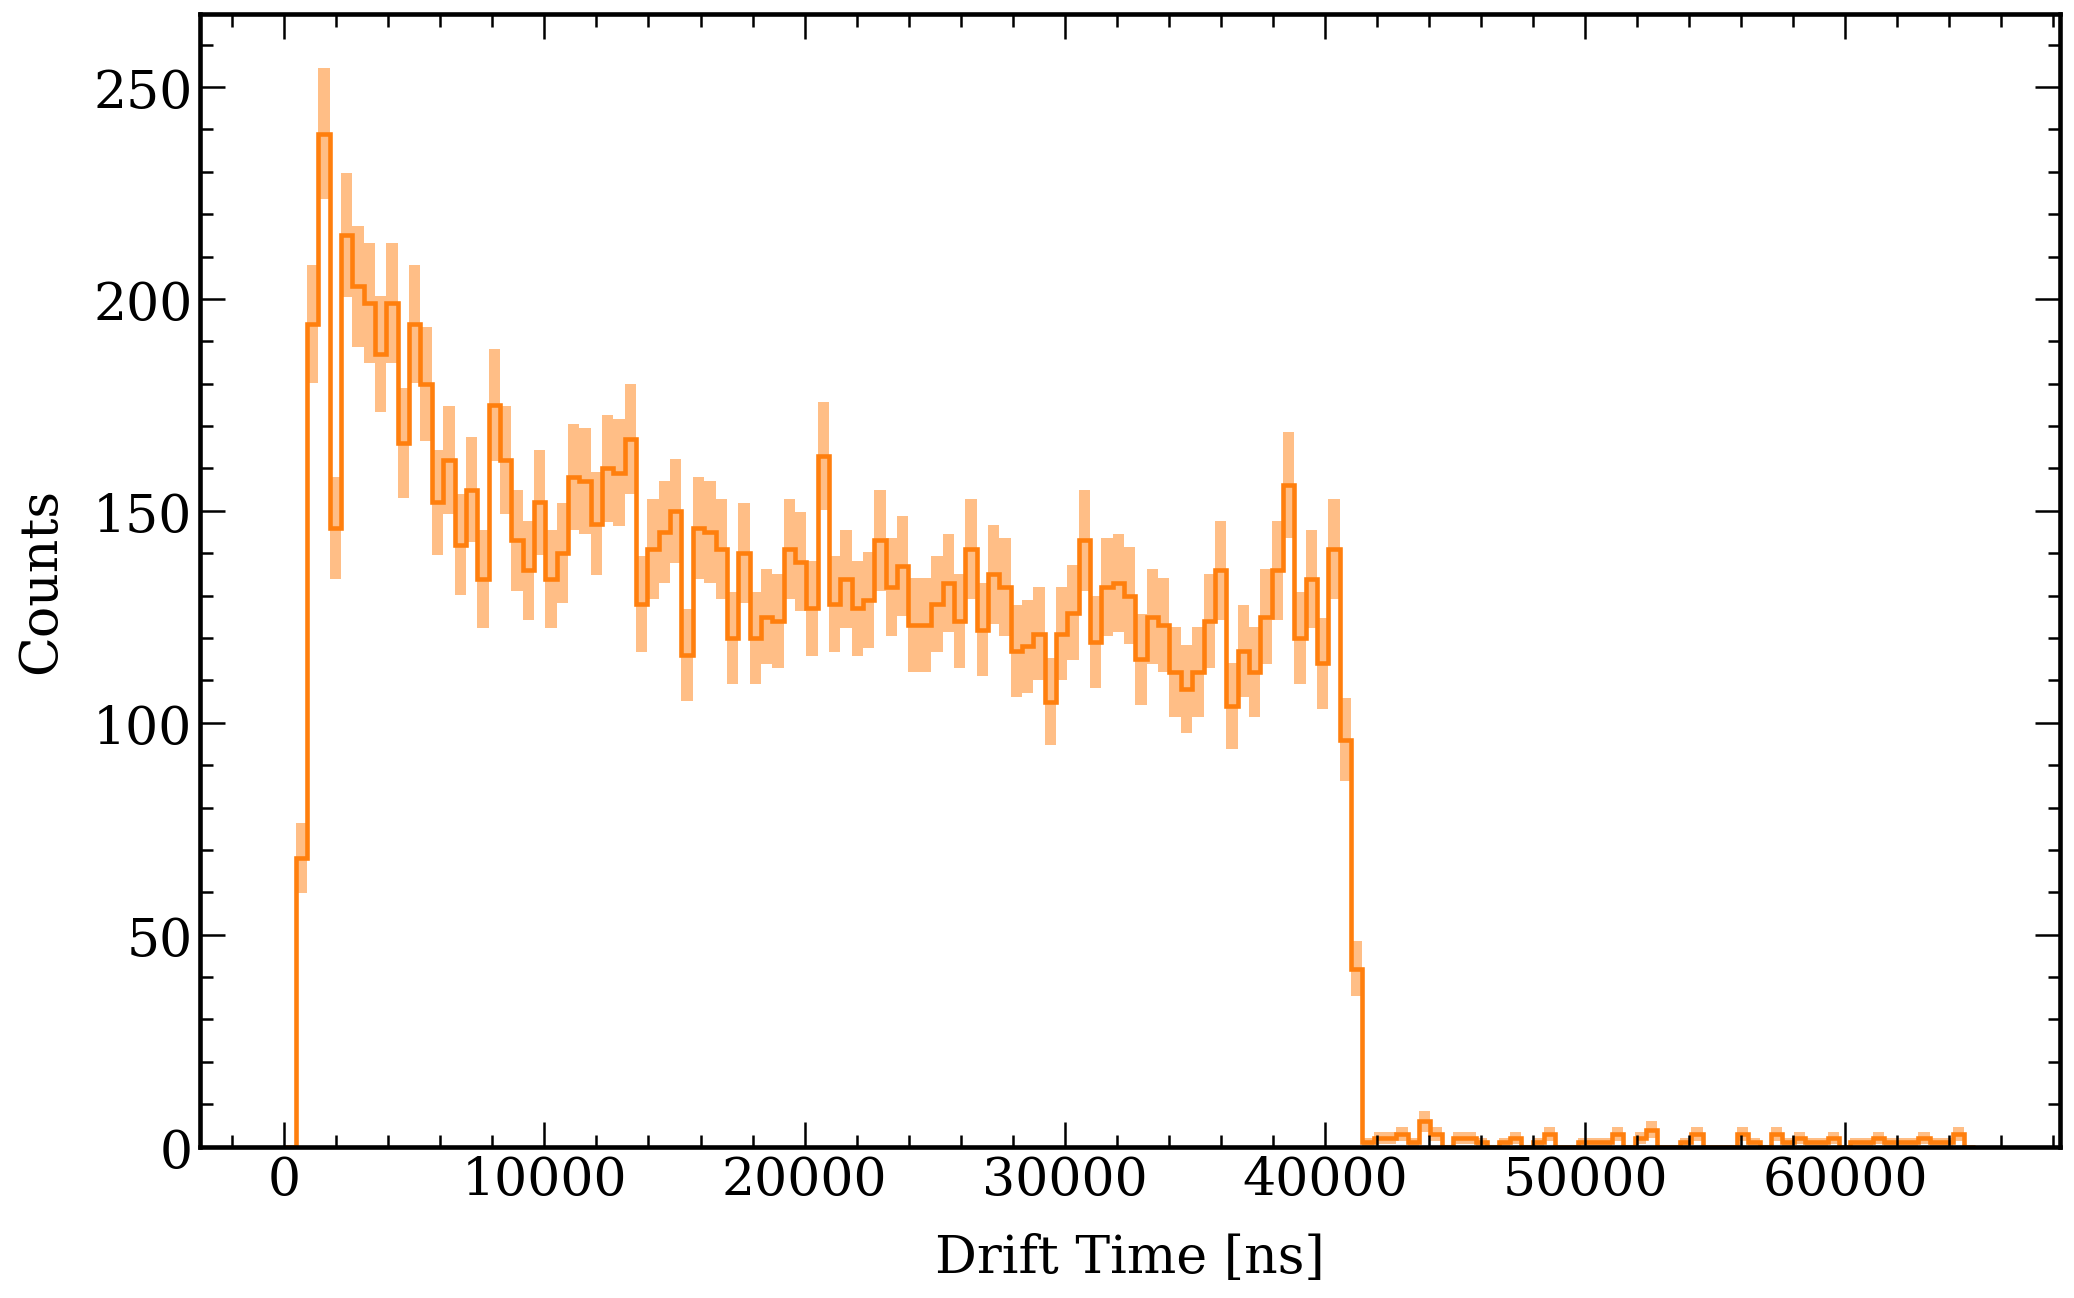

In [437]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################




# Data plot
time_limit = 65000 # 65000 for E_D = 50 V/cm

bins = 150
#bins_x = np.linspace(45000,50000,bins)
bins_x = np.linspace(0,time_limit,bins)
bins_x_center = (bins_x[1:] + bins_x[:-1])/2
bin_fullwidths = (bins_x[1:] - bins_x[:-1])

counts,_, patches = plt.hist(kr_s2_drifttime, bins=bins_x, density = False, 
                             histtype='step', linewidth = 2.2, color = 'C1')



# cut_min_counts = max(counts)*0.05
# cut_min_counts_mask = counts > cut_min_counts

# counts_cut = counts*cut_min_counts_mask
# not_cut = np.sum(cut_min_counts_mask)*time_limit/bins
# bnds = ((not_cut*0.7, max(counts)/4, -max(counts)/not_cut),
#         (time_limit, 2*max(counts), max(counts)/not_cut))
# guess = np.array([40500, 300, 0.005])
# print(bnds)

# drop_first_n = math.ceil(np.sum(cut_min_counts_mask)*0.05) # drop first 5% of entries

# popt, pcov = curve_fit(linstep, bins_x_center[drop_first_n:], 
#                        counts_cut[drop_first_n:], bounds = bnds, p0 = guess)


# print(popt)
# print([np.sqrt(pcov[i,i]) for i in range(len(popt))])


# plt.plot(bins_x_center[10:-60], linstep(bins_x_center[10:-60], *popt), label = 'Linear Fit', color = 'C1')
plt.fill_between(bins_x_center, counts - np.sqrt(counts), counts + np.sqrt(counts), 
                 facecolor='C1', alpha=0.5, step = 'mid')

plt.xlabel('Drift Time [ns]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

#plt.xlim(0, time_limit)
plt.ylim(bottom = 0)

'''# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)'''

#fig.savefig(filenameprefix+"_drifttime.png")
plt.show()

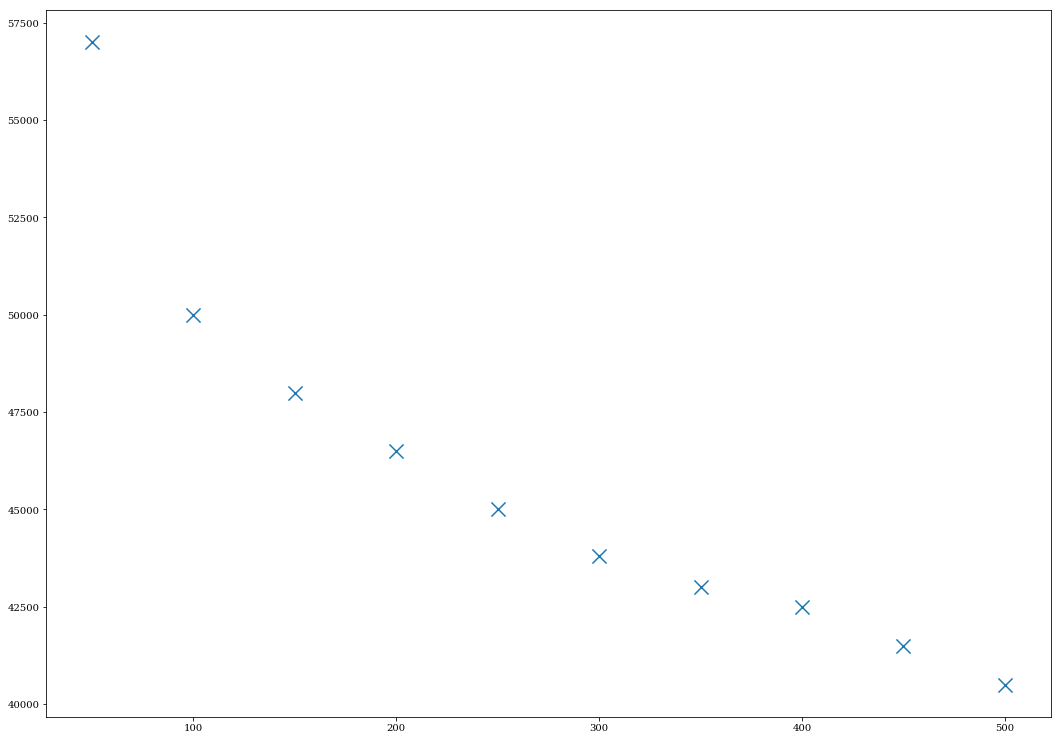

In [438]:
Drift_field = [500,450,400,350,300,250,200,150,100,50]
Drift_time_list = [40500,41500,42500,43000,43800,45000,46500,48000,50000,57000]


fig=plt.figure(figsize=(18, 13))
plt.scatter(Drift_field, Drift_time_list, marker = 'x', s=200)
plt.show()

In [439]:
# number_patch = 80
# number_patch_a = 7
# fig, ax = plt.subplots(figsize=(18,13))
# bins_x = np.linspace(0,65000,100)

# bin_fullwidths = (bins_x[1:] - bins_x[:-1])
# counts,_, patches = plt.hist(kr_s2_drifttime, edgecolor='white', bins=bins_x, color='C2')
# patches[number_patch].set_fc('r')

# print('drifttime is then: ', bins_x[number_patch+1], '+/- ', 0.5*bin_fullwidths[1] )

# ax.set_xlabel('Drift time [us]')
# ax.set_ylabel('S2 counts')
# plt.show()

# # print(len(counts[-85:]))
# # fig, ax = plt.subplots(figsize=(18,13))
# # bins_a = np.linspace(0,300,20)
# # counts_a,_, patches_a = plt.hist(counts[-85:], edgecolor='white', bins=bins_a, color='C2')
# # patches_a[number_patch_a].set_fc('r')
# # plt.show()
# # print(counts[index_max])
# # # print(counts)
# # # print(len(counts))
# # # print(max(counts))
# # # print(bins_x)
# # print(counts[-15:])
# # print(bins_x[-15:])
# # #print(counts.index(max(counts)))

# # for i in range:
# # #     if counts[i] < 0.2 * counts[index_max]:
# # #         print(i)

In [440]:
Average_time_kr_S1 = [j-i for i, j in zip(Timestamps_kr_events[:-1], Timestamps_kr_events[1:])]

max(Average_time_kr_S1)

180536320

6498886.229377603
[2.27234011e+03 1.28548249e-07]


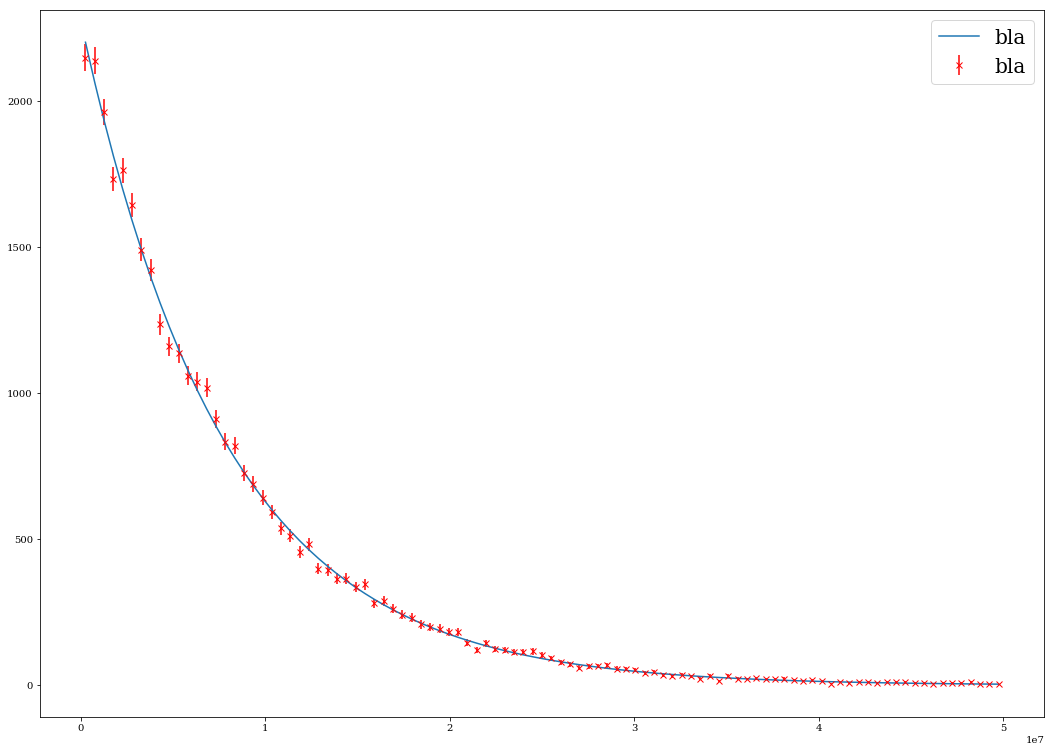

In [441]:
fig, ax = plt.subplots(figsize=(18,13))
def expo(x,a,b):
    expo = a*np.exp(-b*x)
    return expo

p0= [1000,1e-7]
#bounds = ((0, 0),(np.inf, np.inf ))
hist_max = 0.6e8
hist_min = 0.01e8

bins = np.linspace(0, 5e7, 100)
Time_between_krS1, binEdges = np.histogram(Average_time_kr_S1, bins=bins)
bincenters = 0.5 * (binEdges[1:] + binEdges[:-1])
print(1/popt[1]*np.log(2))
popt, pcov = curve_fit(expo, bincenters, Time_between_krS1, p0=p0, sigma = np.sqrt(Time_between_krS1), maxfev =10000)
plt.plot(bincenters, expo(bincenters, *popt), label = 'bla')
plt.errorbar(bincenters, Time_between_krS1, yerr=np.sqrt(Time_between_krS1), fmt = 'rx', label = 'bla' )
plt.legend(prop={'size': 20})
print(popt)
plt.show()

In [442]:
# fig, ax = plt.subplots(figsize=(18,13))
# def expo(x,a,b):
#     expo = a*np.exp(-b*x)
#     return expo


# x_range = np.linspace(0,1e8,100)
# fit_range = np.linspace(0,1e8,len(Average_time_kr_S1))
# p0 = [10,10]
# bins_S1_diff = np.linspace(0,1e8,100)


# #popt,pcov = curve_fit(expo, fit_range, Average_time_kr_S1, sigma = np.sqrt(Average_time_kr_S1), p0 =p0, absolute_sigma = True)
# plt.hist(Average_time_kr_S1, bins = bins_S1_diff,edgecolor='white', color='C2')
# #plt.plot(x_range, expo(x_range, *popt))
# plt.show()


In [443]:
# TPC_length = 71.5


# def power_law(x):

#     power_law = 0.71*x**0.15
#     return power_law
    

# power_law(50)


In [444]:
# drifttime_list = [40707.07070707071]


In [445]:
# list1 = []
# list2 = []
# list3 = []
# full_list = [list1, list2 ,list3]

# for i in range(len(full_list)):
#     full_list[i].append(i)
    
# print(list1)